In [18]:
%matplotlib inline
import pandas as pd
from getdist import plots
from getdist import MCSamples

import matplotlib.pyplot as plt
import numpy as np
from cosmosis.postprocess import parser
from cosmosis.postprocessing.inputs import read_input
from cosmosis.postprocessing.postprocess import postprocessor_for_sampler
from cosmosis.postprocessing.plots import (
    MetropolisHastingsPlots2D,
    MetropolisHastingsPlots1D,
)


import math
from IPython.display import display, Math


In [19]:
%matplotlib inline
def generate_triangle_plot(data_path, params):
    """
    Generates a triangle plot for given parameters from the specified data path.
    
    Parameters:
        data_path (str): Path to the input data.
        params (list of tuples): List of tuples containing parameter names and fiducial values.
    """
    
    data_c = [read_input(data_path)][0]
        
    names = [param[0] for param in params]
    labels = [rf"{param[0]}" for param in params]  # LaTeX-style labels
    fiducial_values = {param[0]: param[1] for param in params}
    
    settings = {
        "mult_bias_correction_order": 0,
        "smooth_scale_2D": 5,  # Increased for smoother 2D contours
        "smooth_scale_1D": 2.5,  # Slight smoothing for 1D histograms
        "boundary_correction_order": 0,
    }
    data_so = [[line[i] for i in range(len(params))] for line in data_c[1]["data"][1][0]]   
    sample_red = MCSamples(samples=np.array(data_so[int(len(data_so) * 0.3) : ]), names=names, labels=labels, settings=settings, root='chain_root')
    print(len(data_so))
    # Triangle plot
    g = plots.get_subplot_plotter()
    g.triangle_plot(
        [sample_red],
        filled=True,
        alphas=[0.8, 0.55],
        contour_ls="-",
        contour_lws=1.5,
        markers=fiducial_values,
        marker_args={"linewidth": 4},
        contour_colors=["#1f77b4"],  # Optional: consistent color
        fine_bins_2D=200,            # Increase bin resolution for smoothness
        interpolation_factor=2,      # Add interpolation for extra smoothness
    )
    #plt.savefig(f'{data_path.replace('number_counts_samples.txt','triangle_plot.png')}')
    plt.show()
    # Get best fit (maximum posterior point)
    best_fit_idx = np.argmax(sample_red.loglikes)
    best_fit_values = {name: sample_red[best_fit_idx, i] for i, name in enumerate(names)}
    
    paraml = [] 
    for param_name in names:
        display(Math(sample_red.getInlineLatex(param_name, limit=1)))
        paraml.append((param_name, best_fit_values[param_name]))
    
    return [data_so, paraml]


LOADING CHAIN FROM FILE:  /sps/lsst/users/ebarroso/CLPipeline/examples/lsst_france/cosmodc2_scaling_relation_false/outputs/output_rp/number_counts_samples.txt
Removed no burn in
1200


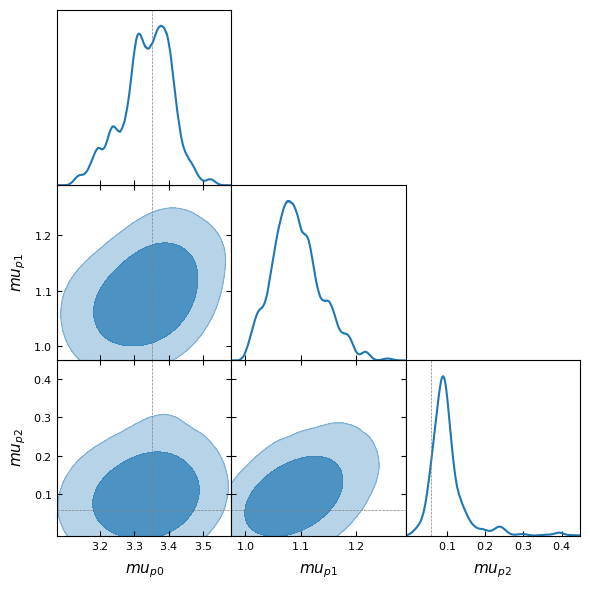

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

LOADING CHAIN FROM FILE:  /sps/lsst/users/ebarroso/CLPipeline/examples/lsst_france/cosmodc2_scaling_relation_false/outputs/output_rp/number_counts.txt
Removed no burn in
1400


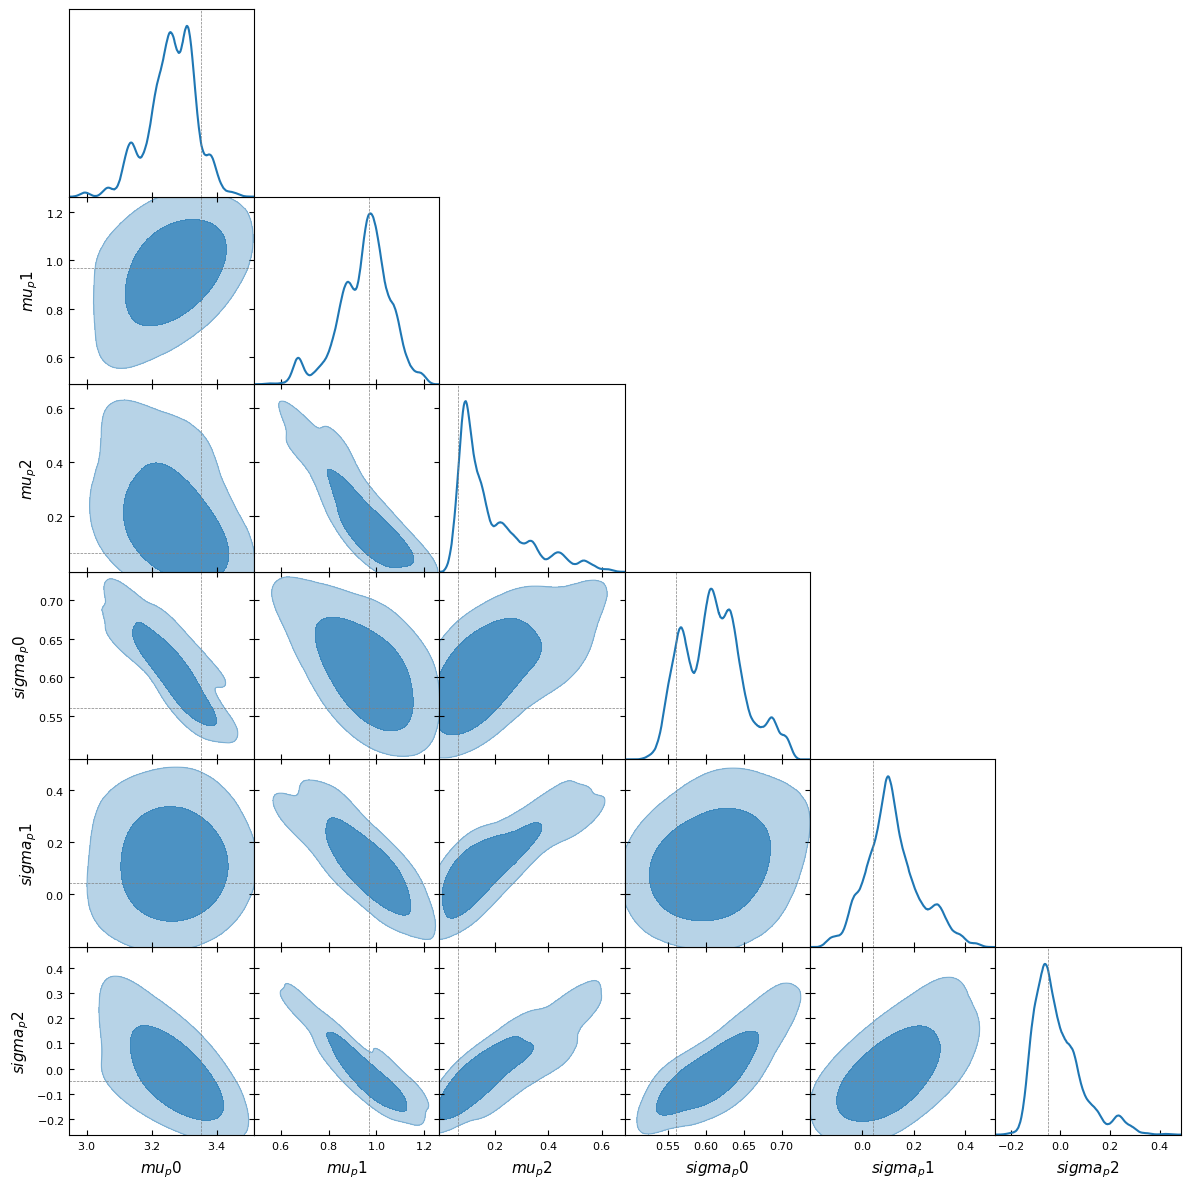

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

LOADING CHAIN FROM FILE:  /sps/lsst/users/ebarroso/CLPipeline/examples/lsst_france/cosmodc2_scaling_relation/outputs/output_rp/number_counts_samples.txt
Removed no burn in
1800


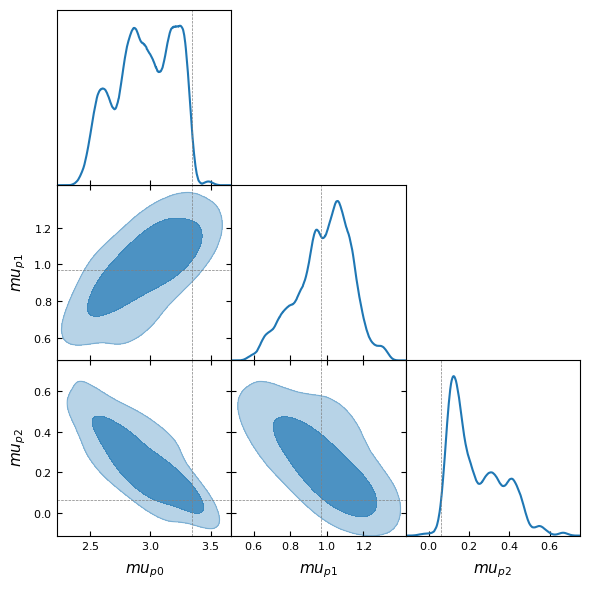

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [20]:
###Change the home path to yours
home = '/sps/lsst/users/ebarroso/'

data_so1= generate_triangle_plot(home + "CLPipeline/examples/lsst_france/cosmodc2_scaling_relation_false/outputs/output_rp/number_counts_samples.txt", [
    ("mu_{p0}",3.35),
    ("mu_{p1}", 0.968),
    ("mu_{p2}", 0.06)
])

data_so2= generate_triangle_plot(home + "CLPipeline/examples/lsst_france/cosmodc2_scaling_relation_false/outputs/output_rp/number_counts.txt", [
    ("mu_p0",3.35),
    ("mu_p1", 0.968),
    ("mu_p2", 0.06),
    ("sigma_p0", 0.56),
    ("sigma_p1", 0.043),
    ("sigma_p2", -0.05)
])

data_so3 = generate_triangle_plot(home + "CLPipeline/examples/lsst_france/cosmodc2_scaling_relation/outputs/output_rp/number_counts_samples.txt", [
    ("mu_{p0}",3.35),
    ("mu_{p1}", 0.968),
    ("mu_{p2}", 0.06)
])

### Prediction versus Data

In [17]:
import sys
sys.path.append('/sps/lsst/users/ebarroso/CLPipeline')
from clpipeline.firecrown_recipes.deltasigma_cp import MurataBinnedSpecZDeltaSigmaSelectionRecipe as MDS
#from firecrown.models.cluster.recipes.murata_binned_spec_z import MurataBinnedSpecZRecipe as MDS
from firecrown.models.cluster.deltasigma import ClusterDeltaSigma
from firecrown.models.cluster.abundance import ClusterAbundance
from firecrown.models.cluster.properties import ClusterProperty
from firecrown.likelihood.binned_cluster_number_counts import BinnedClusterNumberCounts
from firecrown.likelihood.binned_cluster_number_counts_deltasigma import BinnedClusterDeltaSigma
from firecrown.models.cluster.mass_proxy import MurataBinned
import sacc
import pyccl as ccl
import numpy as np
from firecrown.modeling_tools import ModelingTools

In [19]:
def compare_prediction(path, survey_nm, pivot_mass, pivot_redshift, mu_p0, mu_p1, mu_p2, sigma_p0, sigma_p1, sigma_p2, mass_parameter=False):
    s_read = sacc.Sacc.load_fits(path)

    
    hmf = ccl.halos.MassFuncDespali16()
    min_mass, max_mass = 13., 16.
    min_z, max_z = 0.2, 0.8
    cluster_deltasigma = ClusterDeltaSigma((min_mass, max_mass), (min_z, max_z), hmf)
    cluster_abundance = ClusterAbundance((min_mass, max_mass), (min_z, max_z), hmf)
    cosmo_ccl = ccl.Cosmology(
    Omega_c=0.2052,
    Omega_b=0.0448,
    h=0.71,
    n_s=0.963,
    sigma8=0.8,
    Omega_k=0.0,
    Neff=3.044,
    m_nu=0.0,
    w0=-1.0,
    wa=0.0,
    T_CMB=2.7255
    )
    cluster_abundance.update_ingredients(cosmo_ccl)
    cluster_deltasigma.update_ingredients(cosmo_ccl)
    
    modeling_tools = ModelingTools(cluster_abundance = cluster_abundance, cluster_deltasigma=cluster_deltasigma)
    mds = MDS()
    mds.mass_distribution.pivot_mass = np.log(10**pivot_mass)
    mds.mass_distribution.pivot_redshift = pivot_redshift
    mds.mass_distribution.log1p_pivot_redshift = np.log1p(pivot_redshift)
    mds.mass_distribution.mu_p0 = mu_p0
    mds.mass_distribution.mu_p1 = mu_p1
    mds.mass_distribution.mu_p2 = mu_p2
    mds.mass_distribution.sigma_p0 = sigma_p0
    mds.mass_distribution.sigma_p1 = sigma_p1
    mds.mass_distribution.sigma_p2 = sigma_p2
    
    mds.mass_distribution_unb.pivot_mass = np.log(10**pivot_mass)
    mds.mass_distribution_unb.pivot_redshift = pivot_redshift
    mds.mass_distribution_unb.log1p_pivot_redshift = np.log1p(pivot_redshift)
    mds.mass_distribution_unb.mu_p0 = mu_p0
    mds.mass_distribution_unb.mu_p1 = mu_p1
    mds.mass_distribution_unb.mu_p2 = mu_p2
    mds.mass_distribution_unb.sigma_p0 = sigma_p0
    mds.mass_distribution_unb.sigma_p1 = sigma_p1
    mds.mass_distribution_unb.sigma_p2 = sigma_p2

    mds.purity_distribution.ap_nc = 1.98
    mds.purity_distribution.bp_nc = 0.812
    mds.purity_distribution.ap_rc = 2.2183
    mds.purity_distribution.bp_rc = -0.6592
    
    mds.completeness_distribution.ac_nc = 1.1321
    mds.completeness_distribution.bc_nc = 0.7751
    mds.completeness_distribution.ac_mc = 13.31
    mds.completeness_distribution.bc_mc = 0.2025

    
    print(mds.mass_distribution.pivot_mass, mds.mass_distribution.mu_p0, mds.mass_distribution.sigma_p1, mds.mass_distribution.log1p_pivot_redshift )
    average_on = ClusterProperty.DELTASIGMA
    if mass_parameter:
        average_on |= ClusterProperty.MASS
    bin_cl_theory = BinnedClusterDeltaSigma(average_on, survey_nm, mds)
    bin_cl_theory.read(s_read)
    cluster_abundance.update_ingredients(cosmo_ccl)

    prediction = bin_cl_theory._compute_theory_vector(modeling_tools)
    data = bin_cl_theory.data_vector
    return data, prediction3.35


In [30]:
sacc_true = '/sps/lsst/groups/clusters/cl_pipeline_project/TXPipe_data/cosmodc2/outputs-lsst-france/scaling-relation-out/cluster_sacc_catalog.sacc'

survey_name = "cosmodc2-440deg2-CL"
# Firecrown sampled parameter central values
data_so3
mu_p0 = 2.96
mu_p1 = 0.99
mu_p2 = 0.24
sigma_p0 = 0.742
sigma_p1 = 0.058
sigma_p2 = 0.101

pivot_mass = 14.3
pivot_redshift = 0.5

pred_sdss = compare_prediction(sacc_true, survey_name, pivot_mass, pivot_redshift, mu_p0, mu_p1, mu_p2, sigma_p0, sigma_p1, sigma_p2)


32.92696682981485 2.96 0.058 0.4054651081081644


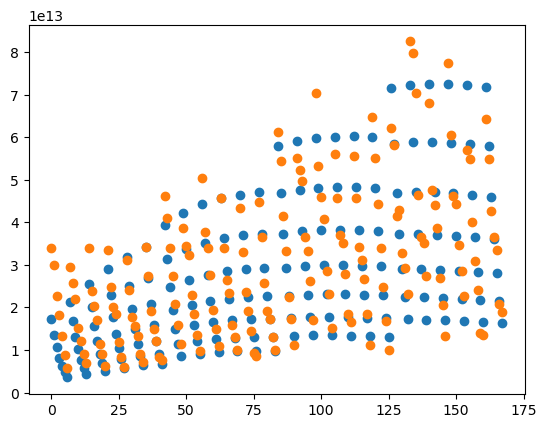

In [34]:
plt.scatter(range(len(pred_sdss[0])), pred_sdss[1])
plt.scatter(range(len(pred_sdss[0])), pred_sdss[0])

In [ ]:
sdss_sacc = '/sps/lsst/groups/clusters/cl_pipeline_project/TXPipe_data/cosmodc2/outputs-lsst-france/scaling-relation-out/cluster_sacc_catalog_wron_bin.sacc'

sdss_survey_name = "cosmodc2-440deg2-CL"
# Firecrown sampled parameter central values
mu_p0 = 3.35
mu_p1 = 2.23 / np.log(10)
mu_p2 = 0.06
sigma_p0 = 0.56014799
sigma_p1 = 0.1 / np.log(10)
sigma_p2 = -0.05

pivot_mass = 14.3
pivot_redshift = 0.5

pred_sdss = compare_prediction(sdss_sacc, sdss_survey_name, pivot_mass, pivot_redshift, mu_p0, mu_p1, mu_p2, sigma_p0, sigma_p1, sigma_p2)


In [35]:
sdss_sacc = '/sps/lsst/groups/clusters/cl_pipeline_project/TXPipe_data/cosmodc2/outputs-lsst-france/scaling-relation-out/cluster_sacc_catalog_wron_bin.sacc'

sdss_survey_name = "cosmodc2-440deg2-CL"
# Firecrown sampled parameter central values
mu_p0 = 3.35
mu_p1 = 2.23 / np.log(10)
mu_p2 = 0.06
sigma_p0 = 0.56014799
sigma_p1 = 0.1 / np.log(10)
sigma_p2 = -0.05

pivot_mass = 14.3
pivot_redshift = 0.5

pred_sdss = compare_prediction(sdss_sacc, sdss_survey_name, pivot_mass, pivot_redshift, mu_p0, mu_p1, mu_p2, sigma_p0, sigma_p1, sigma_p2)


32.92696682981485 3.35 0.04342944819032518 0.4054651081081644


### Prepare Graphs

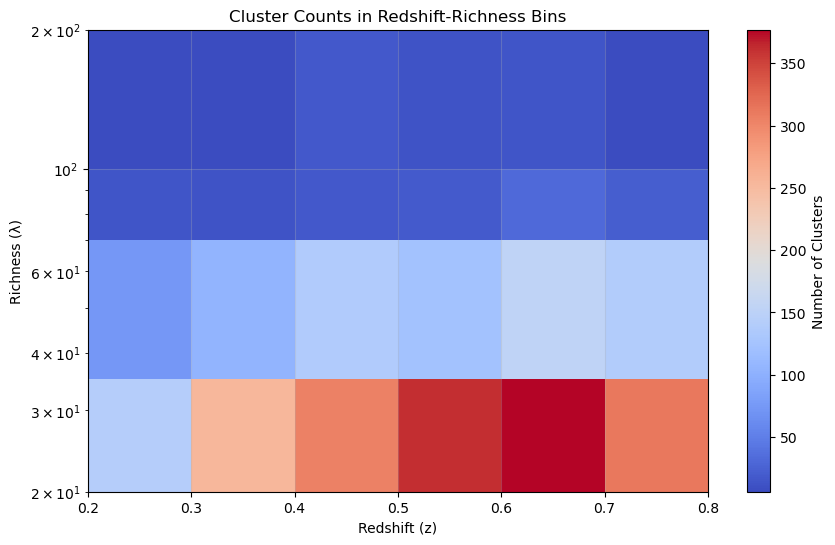

Redshift bin edges: [0.2 0.3 0.4 0.5 0.6 0.7 0.8]
Richness bin edges: [ 20.  35.  70. 100. 200.]


In [48]:
import numpy as np
import matplotlib.pyplot as plt
import sacc

# Load the SACC file
sacc_file = '/sps/lsst/groups/clusters/cl_pipeline_project/TXPipe_data/cosmodc2/outputs-lsst-france/scaling-relation-out_false/cluster_sacc_catalog.sacc'
t = sacc.Sacc.load_fits(sacc_file)

# Get all available redshift and richness bins
z_bins = sorted([name for name in t.tracers.keys() if name.startswith('bin_z_')], key=lambda x: int(x.split('_')[-1]))
rich_bins = sorted([name for name in t.tracers.keys() if name.startswith('bin_rich_')], key=lambda x: int(x.split('_')[-1]))

# Extract bin edges
z_edges = np.array([t.tracers[z_bin].lower for z_bin in z_bins] + [t.tracers[z_bins[-1]].upper])
rich_edges = np.array([10**t.tracers[rich_bin].lower for rich_bin in rich_bins] + [10**t.tracers[rich_bins[-1]].upper])  # Assuming richness is log10

# Initialize a 2D array for counts
counts_2d = np.zeros((len(rich_bins), len(z_bins)))

# Fill the counts matrix
for i, rich_bin in enumerate(rich_bins):
    for j, z_bin in enumerate(z_bins):
        try:
            trac = ('cosmodc2-440deg2-CL', rich_bin, z_bin)
            dp = t.get_data_points(sacc.data_types.standard_types.cluster_counts, trac)
            counts_2d[i, j] = dp[0].value
        except KeyError:
            counts_2d[i, j] = 0  # No clusters in this bin

# Plot the 2D histogram
plt.figure(figsize=(10, 6))

# Use pcolormesh for irregular bin edges
plt.pcolormesh(z_edges, rich_edges, counts_2d, shading='flat', cmap='coolwarm')

# Add colorbar
cbar = plt.colorbar()
cbar.set_label('Number of Clusters')

# Formatting
plt.xlabel('Redshift (z)')
plt.ylabel('Richness (λ)')
plt.title('Cluster Counts in Redshift-Richness Bins')
plt.xlim(z_edges[0], z_edges[-1])
plt.ylim(rich_edges[0], rich_edges[-1])
plt.yscale('log')  # If richness spans orders of magnitude
plt.grid(True, alpha=0.3)

plt.show()

# Print bin edges for reference
print("Redshift bin edges:", z_edges)
print("Richness bin edges:", rich_edges)

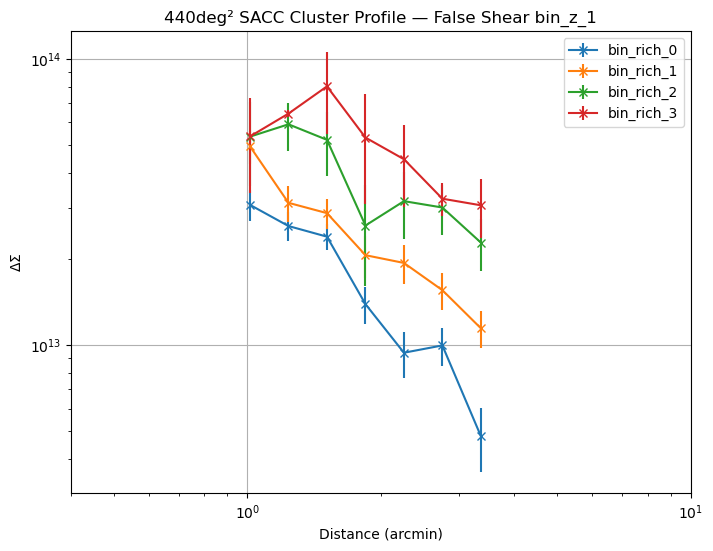

bin_rich_0 = [20.00, 35.00]
bin_rich_1 = [35.00, 70.00]
bin_rich_2 = [70.00, 100.00]
bin_rich_3 = [100.00, 200.00]


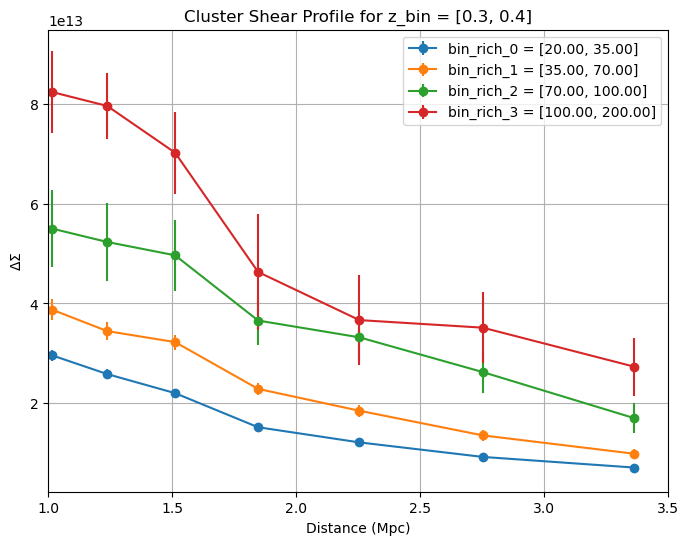

z_bin = [0.3, 0.4]
bin_rich_0 = [20.00, 35.00]
bin_rich_1 = [35.00, 70.00]
bin_rich_2 = [70.00, 100.00]
bin_rich_3 = [100.00, 200.00]


In [53]:
# File paths
sacc_file_true = '/sps/lsst/groups/clusters/cl_pipeline_project/TXPipe_data/cosmodc2/outputs-lsst-france/scaling-relation-out/cluster_sacc_catalog.sacc'
sacc_file_false = '/sps/lsst/groups/clusters/cl_pipeline_project/TXPipe_data/cosmodc2/outputs-lsst-france/scaling-relation-out_false/cluster_sacc_catalog.sacc'

# Load both SACC files
t_true = sacc.Sacc.load_fits(sacc_file_true)
t_false = sacc.Sacc.load_fits(sacc_file_false)

# Select fixed z bin
zbin = 'bin_z_1'

# -------- Plot for FALSE shear -----------------------------------------------------------------
plt.figure(figsize=(8, 6))
for rich_bin_index in range(4):
    rich_bin = f'bin_rich_{rich_bin_index}'

    data = []
    errors = []
    radius_vals = []

    for i in range(7):
        radius_key = f'radius_{i}'
        trac = ('cosmodc2-440deg2-CL', rich_bin, zbin, radius_key)
        radius = t_false.tracers[radius_key].center
        radius_vals.append(radius)

        dp = t_false.get_data_points(sacc.data_types.standard_types.cluster_shear, trac)[0].value
        idx = t_false.indices(sacc.data_types.standard_types.cluster_shear, trac)
        err = np.sqrt(t_false.covariance.covmat[idx][:, idx][0, 0])

        data.append(dp)
        errors.append(err)

    plt.errorbar(radius_vals, data, yerr=errors, label=rich_bin, marker='x')
z_range = t_true.get_tracer(zbin)
plt.xlabel('Distance (arcmin)')
plt.ylabel(r'$\Delta \Sigma$')
plt.title(f'440deg² SACC Cluster Profile — False Shear {zbin}')
plt.xscale('log')
plt.yscale('log')
plt.xlim(0.4, 10)
plt.legend()
plt.grid(True)
plt.show()

# -------- Plot for TRUE shear -------------------------------------------------------------
plt.figure(figsize=(8, 6))
for rich_bin_index in range(4):
    rich_bin = f'bin_rich_{rich_bin_index}'

    data = []
    errors = []
    radius_vals = []

    for i in range(7):
        radius_key = f'radius_{i}'
        trac = ('cosmodc2-440deg2-CL', rich_bin, zbin, radius_key)

        radius = t_true.tracers[radius_key].center
        radius_vals.append(radius)

        dp = t_true.get_data_points(sacc.data_types.standard_types.cluster_shear, trac)[0].value
        idx = t_true.indices(sacc.data_types.standard_types.cluster_shear, trac)---------------------------------------------------------------------------
AttributeError                            Traceback (most recent call last)
Cell In[14], line 6
      4 g.settings.axes_fontsize = 13
      5 range_ = {'1':[2.5,4], '2':[-2,2], '3':[1,4], '4':[0.1,1.2],'5':[-1.5,1.5], '6':[-0.5,0.5], }
----> 6 g.triangle_plot(
      7                 [WLxN,MxN, WLxNlowz], 
      8                 filled=[False, True, False, False, False], 
      9                 contour_colors = ['k', 'orangered', 'darkblue', 'r', 'r', 'k' ], 
     10                 contour_ls=['-','-','--', '--', '-'],
     11                 contour_lws=[1.2,1.2,1.3,2,2],
     12                 legend_fontsize = 10,
     13                 #param_limits=range_,
     14                 params=['1','2','3','4','5','6'],markers=markers,
     15                 fine_bins_2D=200,
     16                 interpolation_factor=2,  marker_args = marker_args, )
     17 plt.savefig(f'../fig/mcmc_scaling_relation_{name}_joint.png', dpi = 300)

File /sps/lsst/users/ebarroso/miniforge3/envs/firecrown_clp/lib/python3.12/site-packages/getdist/plots.py:2549, in GetDistPlotter.triangle_plot(self, roots, params, legend_labels, plot_3d_with_param, filled, shaded, contour_args, contour_colors, contour_ls, contour_lws, line_args, label_order, legend_ncol, legend_loc, title_limit, upper_roots, upper_kwargs, upper_label_right, diag1d_kwargs, markers, marker_args, param_limits, **kwargs)
   2545     self.plot_3d(roots, pair + [col_param], color_bar=False, line_offset=1, add_legend_proxy=False,
   2546                  do_xlabel=i2 == plot_col - 1, do_ylabel=i == 0, contour_args=contour_args,
   2547                  no_label_no_numbers=self.settings.no_triangle_axis_labels, ax=ax, **kwargs)
   2548 else:
-> 2549     self.plot_2d(roots, param_pair=pair, do_xlabel=i2 == plot_col - 1, do_ylabel=i == 0,
   2550                  no_label_no_numbers=self.settings.no_triangle_axis_labels, shaded=shaded,
   2551                  add_legend_proxy=i == 0 and i2 == 1, contour_args=contour_args, ax=ax, **kwargs)
   2552 if marker is not None:
   2553     self._add_marker_list(marker, ax, marker_args)

File /sps/lsst/users/ebarroso/miniforge3/envs/firecrown_clp/lib/python3.12/site-packages/getdist/plots.py:1713, in GetDistPlotter.plot_2d(self, roots, param1, param2, param_pair, shaded, add_legend_proxy, line_offset, proxy_root_exclude, ax, **kwargs)
   1711 contour_args = self._make_contour_args(len(roots), **kwargs)
   1712 for i, root in enumerate(roots):
-> 1713     res = self.add_2d_contours(root, param_pair[0], param_pair[1], line_offset + i, of=len(roots), ax=ax,
   1714                                add_legend_proxy=add_legend_proxy and root not in proxy_root_exclude,
   1715                                **contour_args[i])
   1716     xbounds, ybounds = self._update_limits(res, xbounds, ybounds)
   1717 if xbounds is not None and 'lims' not in kwargs:

File /sps/lsst/users/ebarroso/miniforge3/envs/firecrown_clp/lib/python3.12/site-packages/getdist/plots.py:1123, in GetDistPlotter.add_2d_contours(self, root, param1, param2, plotno, of, cols, contour_levels, add_legend_proxy, param_pair, density, alpha, ax, **kwargs)
   1121 dashes = args.get('dashes')
   1122 if dashes:
-> 1123     for c in cs.collections:
   1124         c.set_dashes([(0, dashes)])
   1125 if proxy_ix >= 0:

AttributeError: 'QuadContourSet' object has no attribute 'collections'
        err = np.sqrt(t_true.covariance.covmat[idx][:, idx][0, 0])

        data.append(dp)
        errors.append(err)
        r = t_true.get_tracer(rich_bin)
    print(f'{rich_bin} = [{10**r.lower:.2f}, {10**r.upper:.2f}]')
    plt.errorbar(radius_vals, data, yerr=errors, label=f'{rich_bin} = [{10**r.lower:.2f}, {10**r.upper:.2f}]', marker='o')

plt.xlabel('Distance (Mpc)')
plt.ylabel(r'$\Delta \Sigma$')
plt.title(f'Cluster Shear Profile for z_bin = [{z_range.lower}, {z_range.upper}]')
# plt.xscale('log')
# plt.yscale('log')
plt.xlim(1, 3.5)
plt.legend()
plt.grid(True)
plt.show()

# -------- Print bin limits --------
z_range = t_false.get_tracer(zbin)
print(f'z_bin = [{z_range.lower}, {z_range.upper}]')

for rich_bin_index in range(4):
    rich_bin = f'bin_rich_{rich_bin_index}'
    r = t_false.get_tracer(rich_bin)
    print(f'{rich_bin} = [{10**r.lower:.2f}, {10**r.upper:.2f}]')

In [122]:
print(r'$mu_{p0}$ = 3.35 \pm 0.01')
print(r'$mu_{p1}$ = 0.96 \pm 0.02')
print(r'$mu_{p2}$ = 0.06 \pm 0.08')

$mu_{p0}$ = 3.35 \pm 0.01
$mu_{p1}$ = 0.96 \pm 0.02
$mu_{p2}$ = 0.06 \pm 0.08
